Username: u155182

### Loading packages
Mostly used sklearn library for ML algorithms

In [1]:
import arff
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import CategoricalEncoder
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.metrics.classification import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

### Loading data
Here I loaded data from .arff file and displayed existing relations.

In [2]:
dataset = arff.load(open('bank.arff', 'r'))
data = np.array(dataset['data'])

X = data[:,0:-1]
y = data[:,-1]

for name, relation in dataset['attributes'][0:-1]:
    print("%10s : %s" % (name, relation))

       age : NUMERIC
       job : ['unemployed', 'services', 'management', 'blue-collar', 'self-employed', 'technician', 'entrepreneur', 'admin.', 'student', 'housemaid', 'retired', 'unknown']
   marital : ['married', 'single', 'divorced']
 education : ['primary', 'secondary', 'tertiary', 'unknown']
   default : ['yes', 'no']
   balance : NUMERIC
   housing : ['yes', 'no']
      loan : ['yes', 'no']
   contact : ['cellular', 'telephone', 'unknown']
       day : NUMERIC
     month : ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'oct', 'sep', 'nov', 'dec']
  duration : NUMERIC
  campaign : NUMERIC
     pdays : NUMERIC
  previous : NUMERIC
  poutcome : ['success', 'failure', 'unknown', 'other']


plus added data from 5th question:

In [3]:
X_q = np.array([['66', 'retired', 'married', 'primary', 'no', '206', 'no', 'no', 'cellular', '9', 'feb', '479', '1', '-1', '0', 'unknown'],
                ['54', 'technician', 'married', 'tertiary', 'no', '876', 'no', 'no', 'cellular', '27', 'oct', '269', '3', '541', '3', 'success']])

### Replacing nominal relations
To use this data we must replace nominal relations. We can encode labels with value between 0 and n_classes-1 or add n_classes dummy values and remove original column. Here we used second option, replaced nominal columns with onehot versions. I used this option because the first one would imply some categories were closer then others, for example encoded value 5 would be "closer" to encoded category 4 than 1. Downside of one-hot option is we will greatly increase number of features, but we can later use PCA to reduce number of features, or just keep the most informative ones.

In [4]:
enc = CategoricalEncoder(encoding='onehot-dense')

X_2 = np.array(X[:,0].reshape(-1,1))
Xq_2 = np.array(X_q[:,0].reshape(-1,1))
attributes = [dataset['attributes'][0][0]]

for i, (name, relation) in enumerate(dataset['attributes'][1:-1]):
    if relation == 'NUMERIC':
        X_2 = np.hstack((X_2, X[:,i + 1].reshape(-1,1)))
        Xq_2 = np.hstack((Xq_2, X_q[:,i + 1].reshape(-1,1)))
        attributes.append(name)
        continue
    
    X_2 = np.hstack((X_2, enc.fit_transform(X[:,i + 1].reshape(-1,1))))
    Xq_2 = np.hstack((Xq_2, enc.transform(X_q[:,i + 1].reshape(-1,1))))
    
    for category in enc.categories_[0]:
        attributes.append(category)
        
X = X_2.astype(float)
X_q = Xq_2.astype(float)

print('Num features: %d' % len(attributes))
print(attributes)

Num features: 51
['age', 'admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management', 'retired', 'self-employed', 'services', 'student', 'technician', 'unemployed', 'unknown', 'divorced', 'married', 'single', 'primary', 'secondary', 'tertiary', 'unknown', 'no', 'yes', 'balance', 'no', 'yes', 'no', 'yes', 'cellular', 'telephone', 'unknown', 'day', 'apr', 'aug', 'dec', 'feb', 'jan', 'jul', 'jun', 'mar', 'may', 'nov', 'oct', 'sep', 'duration', 'campaign', 'pdays', 'previous', 'failure', 'other', 'success', 'unknown']


We now have 51 features, for example feature entrepreneur can get value 0 or 1, 0 meaning persion is not entrepreneur and 1 meaning he is.

### Most informative features
Before we use PCA to remove some features we will see which features are considered most informative when we use Logistic Regression classifier.

In [5]:
def show_most_informative_features(feature_names, clf, n=20):
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print('\t%.4f\t%-15s\t\t%.4f\t%-15s' % (coef_1, fn_1, coef_2, fn_2))

model = LogisticRegression()
model.fit(X, y)
show_most_informative_features(attributes, model)

	-1.3268	jan            		1.6847	mar            
	-1.1013	jul            		1.5177	success        
	-0.9956	unknown        		1.3976	oct            
	-0.9416	unknown        		0.9417	sep            
	-0.9127	nov            		0.8474	retired        
	-0.9093	may            		0.6353	student        
	-0.9053	unemployed     		0.4341	telephone      
	-0.5965	failure        		0.4042	unknown        
	-0.4976	yes            		0.3626	jun            
	-0.4155	no             		0.3164	cellular       
	-0.3764	services       		0.3065	no             
	-0.3532	aug            		0.2244	yes            
	-0.3514	blue-collar    		0.1881	tertiary       
	-0.3511	unknown        		0.1507	admin.         
	-0.3219	self-employed  		0.1297	divorced       
	-0.2508	married        		0.1113	dec            
	-0.2343	yes            		0.0432	no             
	-0.1655	housemaid      		0.0427	feb            
	-0.1413	campaign       		0.0328	technician     
	-0.1284	apr            		0.0115	day            


### PCA
To reduce dimensionality and speed up learning process we can use PCA to reduce number of features. If reduced too much it will reduce expressivenes of the data and we might lose performance.

In [6]:
print('Num features before: %d'% X.shape[1])

pca = PCA(n_components=10)
X = pca.fit_transform(X)
X_q = pca.transform(X_q)

print('Num features after: %d'% X.shape[1])

Num features before: 51
Num features after: 10


### k-NN elbow method
Simple elbow method to determine which K to use when using k-NN.

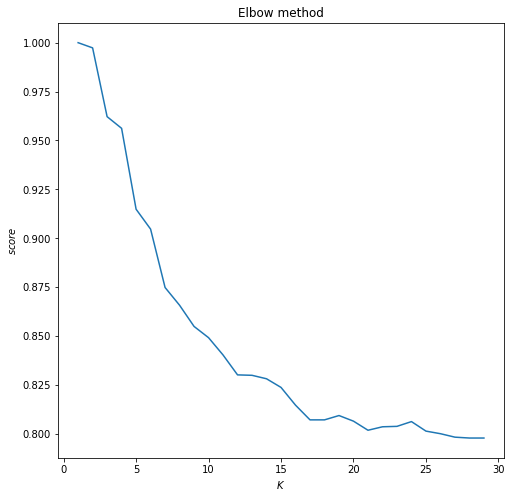

In [7]:
Ks = range(1, 30)
scores = []

for K in Ks:
    model = KNeighborsClassifier(n_neighbors=K)
    model.fit(X, y)
    scores.append(model.score(X, y))

plt.figure(figsize=(8, 8))
plt.plot(Ks, scores)
plt.title('Elbow method')
plt.xlabel('$K$')
plt.ylabel('$score$')
plt.show()

It seems it is best to have K 1 or 2, because any bigger K leads to big performance loss.

### Decision tree max depth
Plotting score depending on max_depth to determine which value of hyperparameter max_depth to use later.

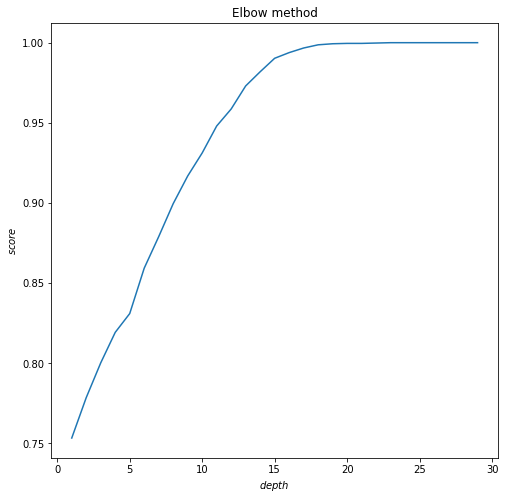

In [8]:
depths = range(1, 30)
scores = []

for depth in depths:
    model = DecisionTreeClassifier(max_depth=depth)
    model.fit(X, y)
    scores.append(model.score(X, y))

plt.figure(figsize=(8, 8))
plt.plot(depths, scores)
plt.title('Elbow method')
plt.xlabel('$depth$')
plt.ylabel('$score$')
plt.show()

I will later use max_depth of 20 because it still greatly impacts performance, any bigger max_depth will not improve performance as much, and might lead to overfitting.

### Accuracy on training data
Here I am calculating accuracy on training data for three different classifiers.

In [9]:
names = ['Logistic Regression', 'K-Nearest Neighbours', 'Decision Tree']

classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(n_neighbors=2),
    DecisionTreeClassifier(max_depth=18)
]

for name, clf in zip(names, classifiers):
    clf.fit(X, y)
    y_pred = clf.predict(X)
    accuracy = accuracy_score(y, y_pred)
    print('%20s accuracy: %.2f' % (name, np.mean(accuracy)))

 Logistic Regression accuracy: 0.80
K-Nearest Neighbours accuracy: 1.00
       Decision Tree accuracy: 1.00


### Cross validation accuracy
Here I am using 10-fold cross validation to determine accuracies of same classifiers.

In [10]:
n_splits = 10

kf = KFold(n_splits)

names = ['Logistic Regression', 'K-Nearest Neighbours', 'Decision Tree']

classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(n_neighbors=2),
    DecisionTreeClassifier(max_depth=20)
]

accuracies = [[], [], []]

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    for clf, acc in zip(classifiers, accuracies):
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        acc.append(accuracy)

for name, acc in zip(names, accuracies):
    print('%20s accuracy: %.2f' % (name, np.mean(acc)))

 Logistic Regression accuracy: 0.79
K-Nearest Neighbours accuracy: 0.94
       Decision Tree accuracy: 0.95


### 1. What is the expected classification accuracy of the default classifier (one which chooses the most common class)?
If this classifier decides by choosing the class with biggest apriori probability I think it's accuracy would be $$\frac{1}{n_classes}$$ because I believe distribution is uniform. So, in this case the accuracy would be 0.5, which is bad.

### 2. Evaluate the accuracy (measured as correctly classified instances percentage) of the models produced by the classification algorithms you know (logistic regression, k-NN, and decision trees) using the training set and 10-fold cross validation. Explain the difference between the two accuracies.
As we've seen above, training set accuracies tend to be higher, because we are testing accuracies on set of data we trained on. This is not always informative as it does not prove our model learned to generalize, it can just mean it learned training data too good (that it has overfitted).

### 3. Using 10-fold cross validation which of the classification algorithms you know has better accuracy?
Looking at the results from above, Decision Tree classifier shows best results with accuracy of 95%.

### 4. What are the 5 attributes most influential attributes for campaign success?
Judging by results from above 5 most informative attributes (from most informative to less informative) seem to be is a person: retired, student, entrepreneur, admin. or a blue-collar.

### 5. What is your prediction for two people with the following characteristics for Age, job, marital, education, default, balance, housing, loan, contact, day, month, duration, campaign, pdays, previous, poutcome:
*Person1: 66, retired, married, primary, no, 206, no, no, cellular, 9, feb, 479, 1, R1, 0, unknown<br>
Person2: 54, technician, married, tertiary, no, 876, no, no, cellular, 27, oct, 269, 3, 541, 3, success*

In [11]:
model = classifiers[2]
y_pred = model.predict(X_q)
print(y_pred)

['yes' 'yes']


Using pretrained decision tree classifier on already transformed data I would classify both examples as yes.